In [2]:
'''This code contains the implementation of simple VAE
Refer to the blog post here: https://graviraja.github.io/vanillavae/

This is a modified version of the above code to generate diagonals.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Dimensions of bars and stripes
m = 2
n = 2

BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 10000           # times to run the model on complete data
INPUT_DIM = m*n     # size of each input
HIDDEN_DIM = 16        # hidden dimension
LATENT_DIM = 2#8         # latent vector dimension
lr = 1e-3               # learning rate

In [4]:
import itertools
def bars_and_stripes(rows, cols):
    
    data = [] 
    
    for h in itertools.product([0,1], repeat=cols):
        pic = np.repeat([h], rows, 0)
        data.append(pic.ravel().tolist())
          
    for h in itertools.product([0,1], repeat=rows):
        pic = np.repeat([h], cols, 1)
        data.append(pic.ravel().tolist())
    
    data = np.unique(np.asarray(data), axis=0)
    
    return data

bas = np.array(bars_and_stripes(m,n)).astype(np.float32).reshape(-1, 1, m, n)
train_dataset = torch.from_numpy(bas)
train_dataset.shape

torch.Size([6, 1, 2, 2])

In [6]:
diagonals = [
    np.array([1,0,0,1]),
    np.array([0,1,1,0]),
]

diags = np.array(diagonals).astype(np.float32).reshape(-1, 1, 2,2)
train_dataset = torch.from_numpy(diags)
train_dataset.shape

torch.Size([2, 1, 2, 2])

In [7]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE
    '''
    def __init__(self, input_dim, hidden_dim, z_dim):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicating the latent dimension.
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]

        return z_mu, z_var

In [8]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self, z_dim, hidden_dim, output_dim):
        '''
        Args:
            z_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
        '''
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        predicted = torch.sigmoid(self.out(hidden))
        # predicted is of shape [batch_size, output_dim]
        return predicted

In [9]:
class VAE(nn.Module):
    def __init__(self, enc, dec):
        ''' This the VAE, which takes a encoder and decoder.
        '''
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var

In [10]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for x in train_dataset:
        # reshape the data into [batch_size, 784]
        x = x.view(-1, m*n)
        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        loss = recon_loss + kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss

In [12]:
best_test_loss = float('inf')
losses = []

for e in range(N_EPOCHS):

    train_loss = train()
    #test_loss = test()

    train_loss /= len(train_dataset)
    #test_loss /= len(test_dataset)

    losses.append(train_loss)
    
    if e % 100 == 0:
        print(f'Epoch {e}, Train Loss: {train_loss:.2f}')

'''
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break
'''

/Users/luisserrano/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 3.02
Epoch 100, Train Loss: 2.90
Epoch 200, Train Loss: 2.72
Epoch 300, Train Loss: 2.88
Epoch 400, Train Loss: 2.13
Epoch 500, Train Loss: 1.77
Epoch 600, Train Loss: 0.89
Epoch 700, Train Loss: 0.99
Epoch 800, Train Loss: 1.06
Epoch 900, Train Loss: 0.96
Epoch 1000, Train Loss: 0.90
Epoch 1100, Train Loss: 0.91
Epoch 1200, Train Loss: 0.87
Epoch 1300, Train Loss: 0.88
Epoch 1400, Train Loss: 0.89
Epoch 1500, Train Loss: 1.00
Epoch 1600, Train Loss: 0.92
Epoch 1700, Train Loss: 0.89
Epoch 1800, Train Loss: 1.53
Epoch 1900, Train Loss: 0.85
Epoch 2000, Train Loss: 1.63
Epoch 2100, Train Loss: 0.95
Epoch 2200, Train Loss: 0.81
Epoch 2300, Train Loss: 1.75
Epoch 2400, Train Loss: 5.90
Epoch 2500, Train Loss: 1.40
Epoch 2600, Train Loss: 0.80
Epoch 2700, Train Loss: 0.88
Epoch 2800, Train Loss: 0.91
Epoch 2900, Train Loss: 8.64
Epoch 3000, Train Loss: 0.88
Epoch 3100, Train Loss: 0.90
Epoch 3200, Train Loss: 0.98
Epoch 3300, Train Loss: 0.93
Epoch 3400, Train Loss: 1.

'\n    if best_test_loss > test_loss:\n        best_test_loss = test_loss\n        patience_counter = 1\n    else:\n        patience_counter += 1\n\n    if patience_counter > 3:\n        break\n'

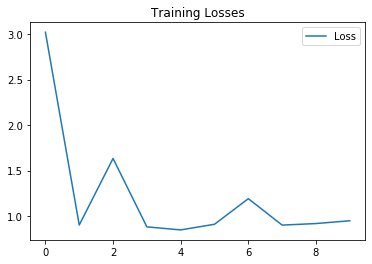

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses[::1000], label='Loss')
plt.title("Training Losses")
plt.legend()

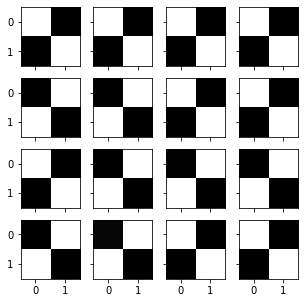

In [14]:
# sample and generate images

images = []
for i in range(16):
    z = torch.randn(1, LATENT_DIM).to(device)
    reconstructed_img = model.dec(z)
    img = reconstructed_img.view(m,n).data
    images.append(img)
    
fig, axes = plt.subplots(figsize = (5,5), nrows=4, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), images):
    im = ax.imshow(img, cmap='gray')